Improvements to the Phoenix model

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
import prepare_phoenix

#{'Teff':data['Teff__0'], 'logg': logg, 'FeH': FeH, 'aM': aM}
Params from B+M 17: https://ui.adsabs.harvard.edu/abs/2017ApJ...845..110B/abstract


In [3]:
#b+m17
#teff = 2650*u.K
#distance = 12.49*u.pc #~consistant with gaia
#mass = 0.080*u.M_sun
#radius = 0.121*u.R_sun

#g+17
#teff = 2559*u.K
#distance = 12.1*u.pc
#mass = 0.080*u.M_sun
#radius = 0.117*u.R_sun

#gonzales+19 w. gaia! https://arxiv.org/pdf/1909.13859.pdf
teff = 2628*u.K
distance = 12.43*u.pc
mass = 90*u.M_jup
radius = 1.16*u.R_jup
logg = 5.21
FeH = 0.04
#g = ((const.G.to(u.cm**3/(u.g*u.s**2))*mass.to(u.g))/(radius.to(u.cm)**2))
#print(g)
#logg = np.log10(g.value)
#print(logg)

In [67]:
star_params =  {'Teff':teff.value, 'logg': logg, 'FeH': 0.0, 'aM': 0}

In [68]:
wavefile= 'phoenix_fits/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'
savepath = ''
pw, pf =prepare_phoenix.make_phoenix_spectrum('trappist-1',wavefile, '.', 'phoenix_fits/', star_params, save_ecsv=True, plot=False)

[[2600, 5.0], [2600, 5.5], [2700, 5.0], [2700, 5.5]]
[2628.0, 5.21]
[array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.1487902e+11,
       3.1647406e+11, 2.8315704e+11], dtype=float32), array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.1006897e+11,
       3.0984860e+11, 2.9560950e+11], dtype=float32), array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.4629209e+11,
       3.4812615e+11, 3.1152482e+11], dtype=float32), array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.4140540e+11,
       3.4165775e+11, 3.2230677e+11], dtype=float32)]


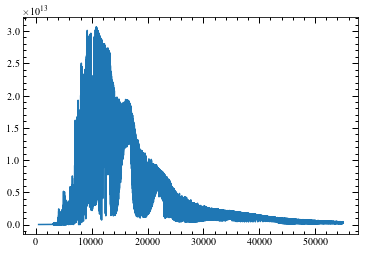

In [6]:
plt.plot(pw, pf)

Ok let's scale with distance and wavelength rather than fitting. Current = 1.59e-28 

In [7]:
old_scale = 1.59e-28
scale = ((radius.to(u.cm)/distance.to(u.cm))**2)*1e-8 #correcting to A
print(scale)
#mscale = 4.7527382752515984e-20

4.675063607400832e-28


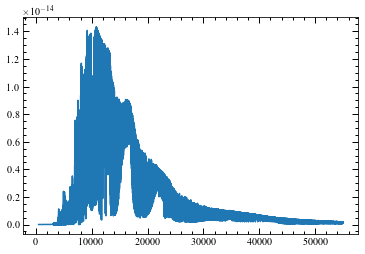

In [8]:
plt.plot(pw, pf*scale)

(0, 3e-14)

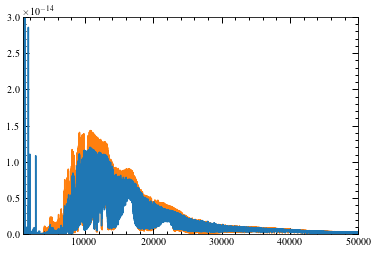

In [9]:
mpath = '/home/david/work/muscles/trappist-1/sp_models/'
mods = os.listdir(mpath)
for mod in mods[0:1]:
    mw, mf = np.loadtxt(mpath+mod, unpack=True, skiprows=1)
    plt.plot(mw, mf*scale/1e-8)
plt.plot(pw,pf*scale, zorder=-1)
plt.xlim(1000, 50000)
plt.ylim(0, 3e-14)
#plt.yscale('log')

In [10]:
#hdul = fits.open('phoenix_fits/lte02500-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

In [11]:
#hdul[0].header

Flux is in per cm not per A!!!!!!! Fixed above. How does that compare to STIS?

In [12]:
stis_opt = 'odlm41010_sx1.fits'
data = fits.getdata('../combined/'+stis_opt,1)[0]
wo = data['WAVELENGTH'][data['DQ']==0]
fo = data['FLUX'][data['DQ']==0]
mask = (fo>0) &  (wo <3355) | (wo > 3365) & (wo < 5321) | (wo > 5325) & (wo < 5476.5) | (wo > 5480.5) #cutting out overlap and cosmics
wo, fo = wo[mask], fo[mask]

(1e-30, 1e-13)

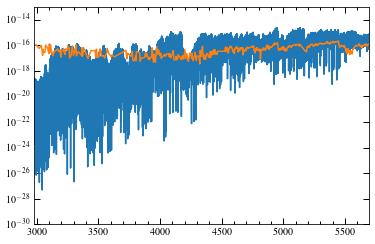

In [13]:
plt.plot(pw, pf*scale)
plt.plot(wo, fo)
plt.xlim(wo[0], wo[-1])
#plt.ylim(-0.1e-15, 0.3e-14)
plt.yscale('log')
plt.ylim(1e-30, 1e-13)

Reasonable, I think this is the better way forward given the scaling is almost included by the choice of model. What about the ir data?

In [14]:
irpath = '/home/david/work/muscles/SEDs/trappist-1/ir_data/'
#sps = os.listdir(irpath) 
sps = glob.glob(irpath+'*.fits')
sps

['/home/david/work/muscles/SEDs/trappist-1/ir_data/mage_2306-0502_090827.fits',
 '/home/david/work/muscles/SEDs/trappist-1/ir_data/spex_sxd-merge_2306-0502_151118.fits',
 '/home/david/work/muscles/SEDs/trappist-1/ir_data/spex_prism_2306-0502_030905.fits']

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


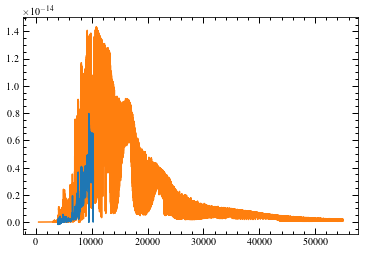

 ############################## Xspextool History ############################## [astropy.io.fits.card]
 ############################## Xcombspec History ############################## [astropy.io.fits.card]
 ############################### Xtellcor History ############################## [astropy.io.fits.card]
 ############################# Xmergeorders History ############################ [astropy.io.fits.card]


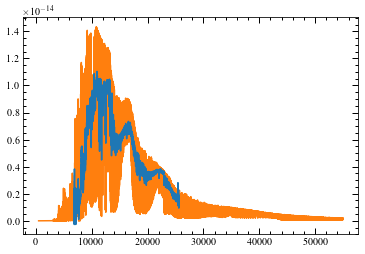

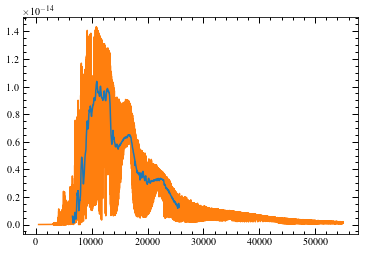

In [15]:
for i, sp in enumerate(sps):
  #  hdul = fits.open(sp, ignore_missing_end=True)
    
    #data = hdul[0].data
    data = fits.getdata(sp,0)
   # hdul.close()
    w, f, e = data[0], data[1], data[2]
    if i == 0:
        e = e/f
        f = (f *1e-3*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(w * u.AA)).value
        #e = e*f
        f /=10
        e = e*f
        #clip = 100
        mask = (w > 4000)
        #w, f, e = w[clip:], f[clip:], e[clip:]
        w, f, e = w[mask], f[mask], e[mask]
    if i > 0:
        w *= 10000
    if i == 1:
        w, f, e, = w[:-10], f[:-10], e[:-10] #bad edge pixels
    if i ==2:
        f /=10 #erg/nm to erg/A I assume?
    plt.plot(w,f)
    name = os.path.split(sp)[1][:-5]
    #print(name)
    savedat = Table([w*u.AA, f*u.erg/u.cm**2/u.s/u.AA, e*u.erg/u.cm**2/u.s/u.A], names=['WAVELENGTH', 'FLUX', 'ERROR'])
    ascii.write(savedat, irpath+name+'.ecsv', overwrite=True, format='ecsv')
    #plt.plot(w,e)
    #plt.plot(w, f/e)
    #plt.xlim(3000, 4000)
    plt.plot(pw, pf*scale, zorder=-1)
    plt.show()
    #hdul[0].header
   

In [16]:
fits.getheader(sps[2])

SIMPLE  =                    T /image conforms to FITS standard                 
BITPIX  =                  -32 /bits per data value                             
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                  562 /                                                
NAXIS2  =                    3 /                                                
EXTEND  =                    T /file may contain extensions                     

In [17]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

In [18]:
mage_res = 4100
sxd_res = 2000
prism_res = 200
reses = [mage_res, sxd_res, prism_res]

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


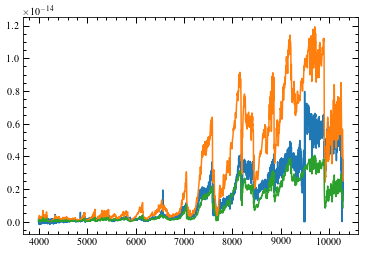

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


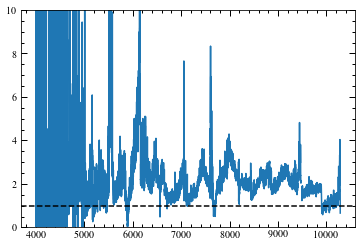

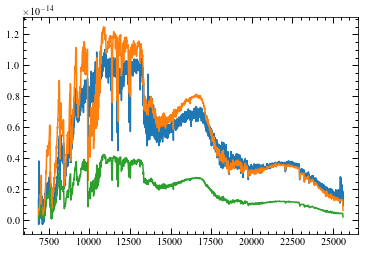

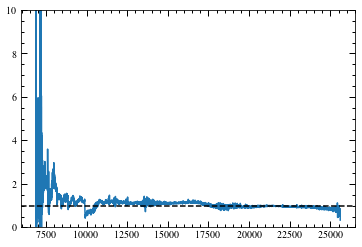

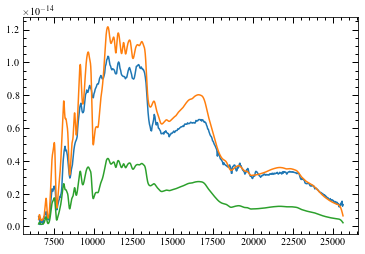

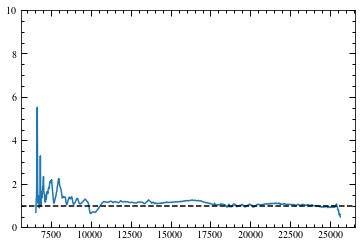

In [19]:
for i, sp in enumerate(sps):
  #  hdul = fits.open(sp, ignore_missing_end=True)
    
    #data = hdul[0].data
    data = fits.getdata(sp,0)
   # hdul.close()
    w, f, e = data[0], data[1], data[2]
    if i == 0:
        e = e/f
        f = (f *1e-3*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(w * u.AA)).value
        e = e*f
        f /=10
        #clip = 100
        mask = (w > 4000)
        #w, f, e = w[clip:], f[clip:], e[clip:]
        w, f, e = w[mask], f[mask], e[mask]
    if i > 0:
        w *= 10000
    if i == 1:
        w, f, e, = w[:-10], f[:-10], e[:-10] #bad edge pixels
    if i ==2:
        f /=10 #erg/nm to erg/A I assume?
    plt.plot(w,f)
    #plt.plot(w,e)
    #plt.plot(w, f/e)
    #plt.xlim(3000, 4000)
    pmask = (pw >= w[0]) & (pw <= w[-1])
    pwr, pfr = pw[pmask],(pf*scale)[pmask]
    pwr, pfr = smear(pwr, pfr, reses[i])
    plt.plot(pwr, pfr)
    plt.plot(pwr, pfr*(old_scale/scale))
    plt.show()
    pfi = interp1d(pwr, pfr, fill_value='extrapolate')(w)
    plt.plot(w, pfi/f)
    plt.axhline(1, ls='--',c='k')
    plt.ylim(0,10)
    plt.show()
    #hdul[0].heade

A bit high in all three cases? A factor 2 missing somewhere? How do the three spectra compare themselves? Trying with different distance  

Changed to G+ values, much better agreement. Scale radius to Gaia?

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


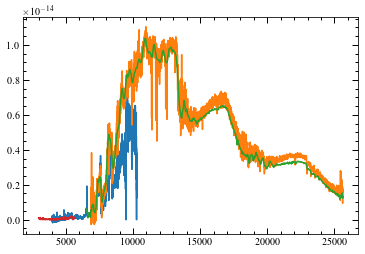

In [20]:
for i, sp in enumerate(sps):
    data = fits.getdata(sp,0)
    w, f, e = data[0], data[1], data[2]
    if i == 0:
        e = e/f
        f = (f *1e-3*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(w * u.AA)).value
        e = e*f
        f /=10
        #clip = 100
        mask = (w > 4000)
        #w, f, e = w[clip:], f[clip:], e[clip:]
        w, f, e = w[mask], f[mask], e[mask]
    if i > 0:
        w *= 10000
    if i == 1:
        w, f, e, = w[:-10], f[:-10], e[:-10] #bad edge pixels
    if i ==2:
        f /=10 #erg/nm to erg/A I assume?
    plt.plot(w,f)
plt.plot(wo, fo)



findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


4.7527382752515984e-20


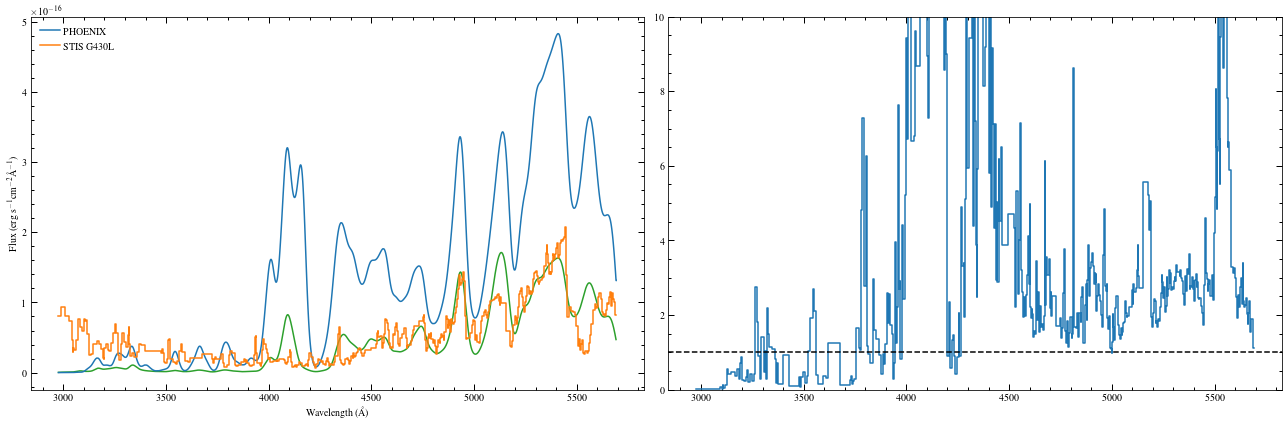

In [21]:
shift = 1
#plt.plot(w2fit, f2fit)
plt.figure(figsize=(18,6))
plt.subplot(121)
pmask = (pw >= wo[0]) & (pw <= wo[-1])
pwr, pfr = pw[pmask],(pf*scale)[pmask]
pwr, pfr = smear(pwr, pfr,250)
plt.step(pwr, pfr/shift, label='PHOENIX', where='mid')
fob = convolve(fo,Box1DKernel(2))
plt.step(wo, fob, where='mid', label='STIS G430L')
plt.legend(loc=2)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')

mscale = (((0.117*u.R_sun.to(u.cm))/(12.1*u.pc.to(u.cm)))**2)
print(mscale)
mwr, mfr = smear(mw[(mw >= wo[0]) & (mw <= wo[-1])], (mf*mscale)[(mw >= wo[0]) & (mw <= wo[-1])], 250)
plt.plot(mwr, mfr, zorder=-1)



plt.subplot(122)
pfi = interp1d(pwr, pfr, fill_value='extrapolate')(wo)
plt.step(wo, (pfi/shift)/fo, where='mid')
plt.ylim(0,10)
plt.axhline(1, ls='--',c='k')
plt.tight_layout()

Have a new cgs spectrum from MV

In [22]:
newspec = glob.glob(irpath+'*.txt')[0]
newspec

'/home/david/work/muscles/SEDs/trappist-1/ir_data/trappist1_ir.txt'

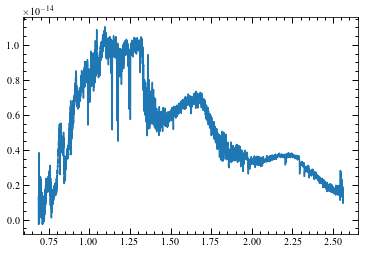

In [23]:
wn, fn = np.loadtxt(newspec, unpack=True)
plt.plot(wn[:-10], fn[:-10])

In [24]:
#fits.getheader('lte02500-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

In [25]:
#plt.step(wo, fo, where='mid')
#for smooth in (5,5):#, 10, 15, 20):
 #   plt.step(wo, convolve(fo,Box1DKernel(smooth)), where='mid', label=str(smooth))
#plt.legend()

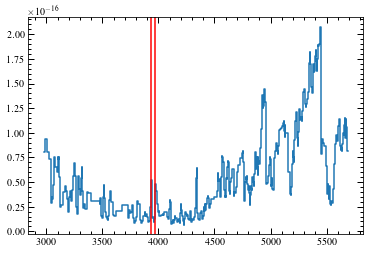

In [26]:
ca =[ 3933.6614, 3968.4673]
plt.step(wo,  convolve(fo,Box1DKernel(2)), where='mid')
[plt.axvline(line, c='r') for line in ca]

Hey look Ca H&K lines! How does photometry compare?

In [27]:
phottab = 'trappist-1_vizer_photometry.vot'
from astropy.io.votable import parse
votable = parse(phottab)
table = votable.get_first_table()
data = table.array

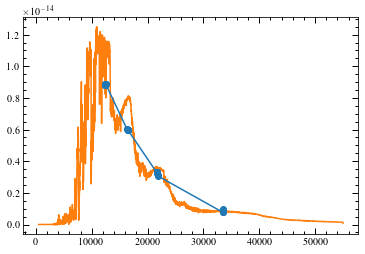

In [28]:
mask = ~data['sed_eflux'].mask
masked_data = data[mask].data

wt, ft, et = masked_data['sed_freq']*u.GHz, masked_data['sed_flux']*u.Jy, masked_data['sed_eflux']*u.Jy
#plt.errorbar(wt, ft, yerr=et, marker='o')
et = et.value/ft.value
wt = wt.to(u.AA, equivalencies=u.spectral())
ft = ft.to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(wt))
et = et*ft

#print(wt, ft, et)
args = np.argsort(wt)
wt, ft, et = wt[args], ft[args], et[args]
plt.errorbar(wt.value, ft.value, yerr=et.value, marker='o')
pwr, pft = smear(pw, pf*scale,2000)
plt.plot(pwr, pft)

Ok, looks like the model is a factor two out. How do we fix that? It's the model not the scaling, SP's model fits.  

Checking this- compare with all three sets of parameters...

In [29]:

def find_logg(mass, radius):
    g = (const.G.to(u.cm**3/(u.g*u.s**2))*mass.to(u.g))/(radius.to(u.cm)**2)
    return np.log10(g.value)

FeH = 0.04

radii = []
#b+m17
teff = 2650*u.K
bm_distance = 12.49*u.pc #~consistent with gaia
mass = 0.080*u.M_sun
radius = 0.121*u.R_sun
radii.append(radius)
logg = find_logg(mass, radius)
print(logg)
bm17_params = {'Teff':teff.value, 'logg': logg, 'FeH': FeH, 'aM': 0}


#g+17
teff = 2559*u.K
g17_distance = 12.1*u.pc
mass = 0.080*u.M_sun
radius = 0.117*u.R_sun
radii.append(radius)
logg = find_logg(mass, radius)
print(logg)
g17_params = {'Teff':teff.value, 'logg': logg, 'FeH': FeH, 'aM': 0}


#gonzales+19 w. gaia! https://arxiv.org/pdf/1909.13859.pdf
teff = 2628*u.K
g19_distance = 12.43*u.pc
mass = 90*u.M_jup
radius = 1.16*u.R_jup
radii.append(radius)
logg = 5.21
g19_params = {'Teff':teff.value, 'logg': logg, 'FeH': FeH, 'aM': 0}

params = [bm17_params, g17_params, g19_params]
distances = [bm_distance, g17_distance, g19_distance]
names = ['bm17', 'g17','g19']

5.175586873662176
5.204785890802754


In [30]:
def save_to_ecsv(star,wavelength, flux, save_path):
    """
    save the new model to an ecsv file
    """
    if os.path.exists(save_path) == False:
        os.mkdir(save_path)
    savedat = Table([wavelength*u.AA, flux*u.erg/u.cm**2/u.s/u.AA], names=['WAVELENGTH', 'FLUX'])
    ascii.write(savedat, save_path+star+'_phoenix_interpolated.ecsv', overwrite=True, format='ecsv')

wavefile= 'phoenix_fits/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'
savepath = ''

scales =[]
for star_params, distance, name, radius in zip(params, distances, names, radii):
    pw, pf =prepare_phoenix.make_phoenix_spectrum('trappist-1',wavefile, '.', 'phoenix_fits/', star_params, save_ecsv=True, plot=False)
    scale = ((radius.to(u.cm)/distance.to(u.cm))**2)*1e-8 #correcting to A
    scales.append(scale)
    save_to_ecsv(name+'_trappist-1_scaled', pw, pf*scale, 'phoenix_spectra/')



[[2600, 5.0, 0.0], [2600, 5.0, 0.5], [2600, 5.5, 0.0], [2600, 5.5, 0.5], [2700, 5.0, 0.0], [2700, 5.0, 0.5], [2700, 5.5, 0.0], [2700, 5.5, 0.5]]
[2650.0, 5.175586873662176, 0.04]
[array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.1487902e+11,
       3.1647406e+11, 2.8315704e+11], dtype=float32), array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.1816244e+11,
       3.2762102e+11, 2.7625973e+11], dtype=float32), array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.1006897e+11,
       3.0984860e+11, 2.9560950e+11], dtype=float32), array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.0928106e+11,
       3.0942999e+11, 2.7766083e+11], dtype=float32), array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.4629209e+11,
       3.4812615e+11, 3.1152482e+11], dtype=float32), array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.5221252e+11,
       3.6273691e+11, 3.1109189e+11], dtype=float32), array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.41405

In [31]:
scaled_sp = glob.glob('phoenix_spectra/'+'*.ecsv')
#print(scaled_sp)
pm = Table.read(scaled_sp[0])
pw = pm['WAVELENGTH']
pf1 = pm['FLUX']
pm = Table.read(scaled_sp[1])
pf2 = pm['FLUX']
pm = Table.read(scaled_sp[2])
pf3 = pm['FLUX']

pfs = [pf1, pf2, pf3]
#print(pfs)

#for i, sp in enumerate(scaled_sp):
 #   pm = Table.read(sp)
   # if i == 0:
    #    pw = pm['WAVELENGTH']#np.stack(pws, pm['WAVELENGTH'])
     #   pfs = np.array(pm['FLUX'])
    #else:
     #   pfs = np.stack(pfs,pm['FLUX'])print(pfs)
#for pf in pfs:
 #   plt.plot(pw, pf)

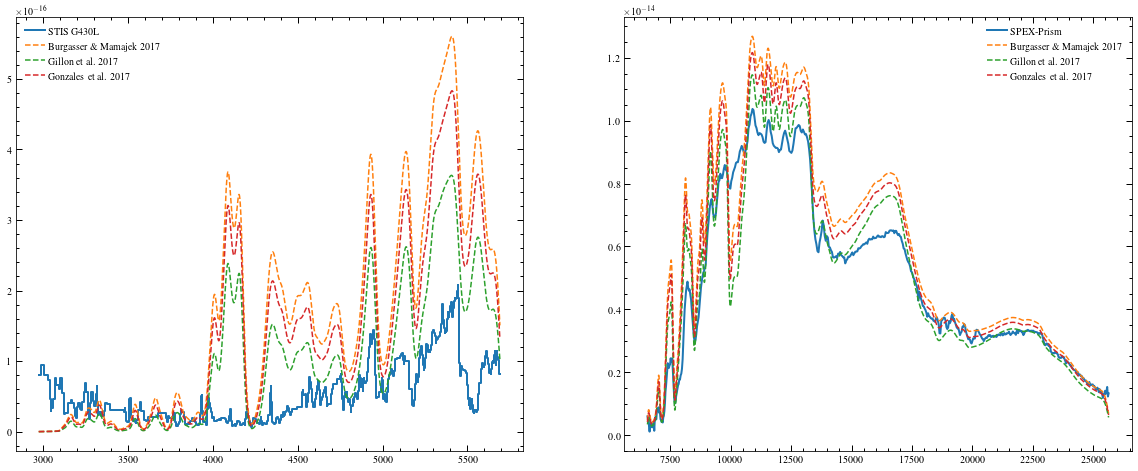

In [32]:
#spex = Table.read(irpath+'spex_sxd-merge_2306-0502_151118.ecsv')
spex = Table.read(irpath+'spex_prism_2306-0502_030905.ecsv')

#labels = ['BM17', r'G+17', r'G+19'] 
labels = ['Burgasser \& Mamajek 2017', 'Gillon et al. 2017', 'Gonzales et al. 2017']
plt.figure(figsize=(20, 8))
plt.subplot(121)
fob = convolve(fo,Box1DKernel(2))
plt.step(wo, fob, where='mid', label='STIS G430L', lw=2)
for i, pf in enumerate(pfs):
    
    pmask = (pw >= wo[0]) & (pw <= wo[-1])
    pwr, pfr = pw[pmask],(pf)[pmask]
    pwr, pfr = smear(pwr, pfr,250)
    plt.plot(pwr, pfr, label=labels[i], ls='--')


plt.legend(loc=2)
    
plt.subplot(122)
wir, fir= spex['WAVELENGTH'], spex['FLUX'] 
#firb = convolve(fir,Box1DKernel(2))
plt.plot(wir, fir, label='SPEX-Prism', lw=2)
for i, pf in enumerate(pfs):
    pmask = (pw >= spex['WAVELENGTH'][0]) & (pw <= spex['WAVELENGTH'][-1])
    pwr, pfr = pw[pmask],(pf)[pmask]
    pwr, pfr = smear(pwr, pfr,prism_res)
    plt.plot(pwr, pfr, label=labels[i], ls='--')
    
#plt.errorbar(wt.value, ft.value, yerr=et.value, marker='o')    
plt.legend(loc=1)

(0, 3e-16)

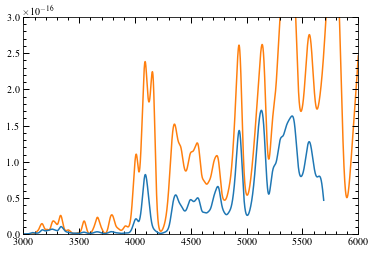

In [33]:
plt.plot(mwr, mfr)
pwr, pf1r = smear(pw, pf2, 250)
plt.plot(pwr, pf1r, zorder=-1)
plt.xlim(3000, 6000)
plt.ylim(0, 0.3e-15)

Check if the Phoenix files are interpolating correctly.

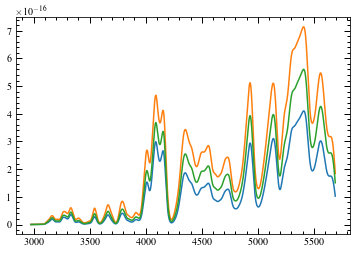

In [34]:
pmask = (pw >= wo[0]) & (pw <= wo[-1])
pfits = fits.getdata('phoenix_fits/lte02600-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

pwr, pfr = smear(pw[pmask], pfits[pmask]*scales[0], 250) 
plt.plot(pwr, pfr)
pfits = fits.getdata('phoenix_fits/lte02700-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

pwr, pfr = smear(pw[pmask], pfits[pmask]*scales[0], 250) 
plt.plot(pwr, pfr)

pwr, pfr = smear(pw[pmask], pf1[pmask], 250) 

plt.plot(pwr, pfr)

In [35]:
print (scales)
print(mscale)

[<Quantity 4.7707733e-28>, <Quantity 4.75273828e-28>, <Quantity 4.67506361e-28>]
4.7527382752515984e-20


The fault is in our models. The Gottigen ones are out of date. Where do P+19 get theirs? Calculated by hand. Ok, let's take the G+19 ones and rescale them.

In [36]:
from craftroom import resample

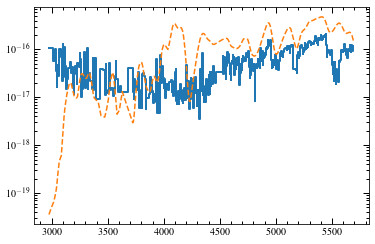

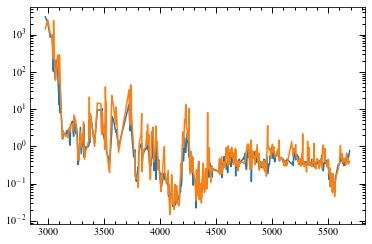

In [37]:
#fob = convolve(fo,Box1DKernel(2))
plt.step(wo, fo, where='mid', label='STIS G430L', lw=2)

pmask = (pw >= wo[0]) & (pw <= wo[-1])
pwi, pfi = pw[pmask], pf3[pmask]
pwi, pfi = resample.bintogrid(pwi, pfi, newx = wo)

#pwr, pfr = pw[pmask],(pf2)[pmask]
pwr, pfr = smear(pwi, pfi,250)
plt.plot(pwr, pfr, label=labels[i], ls='--')
plt.yscale('log')
plt.show()
#pwi, pfi = resample.bintogrid(pwr, pfr, newx = wo)
plt.plot(wo, fo/pfr)
plt.plot(wo, fo/pfi)
plt.yscale('log')

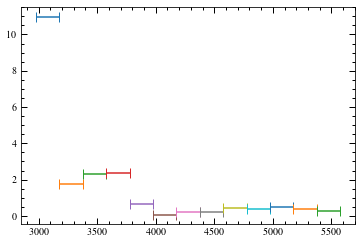

0.3444070839464134
1.6101250242889206e-28
1.59e-28


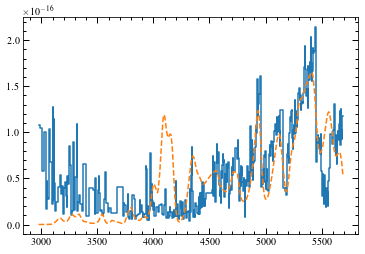

In [38]:
ratios =[]
bandwidth = 200
bands = np.arange(wo[0], wo[-1], bandwidth)
for band in bands[:-1]:
    bmask = (wo > band) & (wo < band+bandwidth)
    p_flux = np.trapz(pfi[bmask], wo[bmask])
    o_flux = np.trapz(fo[bmask], wo[bmask])
    ratios.append(o_flux/p_flux)
    plt.errorbar(band+bandwidth/2, o_flux/p_flux, xerr=bandwidth/2, capsize=5)
plt.show()
#print(ratios)

cut = 4000
c_mask = (bands[:-1] > cut)
mean_ratio = np.mean(np.array(ratios)[c_mask])
print(mean_ratio)
print(scales[2]*mean_ratio)
print(old_scale)

plt.step(wo, fo, where='mid', label='STIS G430L')

pwr, pfr = smear(pwi, pfi,250)
plt.plot(pwr, pfr*mean_ratio, label=labels[i], ls='--')
#plt.yscale('log')
plt.show()

What about the IR?

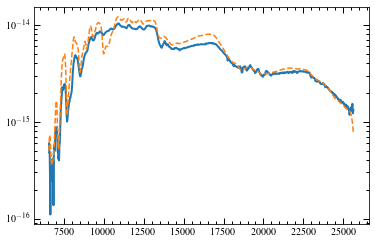

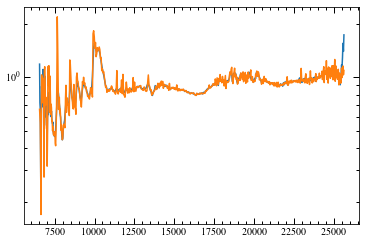

In [39]:
#fob = convolve(fo,Box1DKernel(2))
plt.plot(wir, fir, label='SPEX-Prism', lw=2)

#plt.step(wo, fo, where='mid', label='STIS G430L', lw=2)

pmask = (pw >= wir[0]) & (pw <= wir[-1])
pwi, pfi = pw[pmask], pf3[pmask]
pwi, pfi = resample.bintogrid(pwi, pfi, newx = wir)

#pwr, pfr = pw[pmask],(pf2)[pmask]
pwr, pfr = smear(pwi, pfi,prism_res)
plt.plot(pwr, pfr, label=labels[i], ls='--')
plt.yscale('log')
plt.show()
#pwi, pfi = resample.bintogrid(pwr, pfr, newx = wo)
plt.plot(wir, fir/pfr)
plt.plot(wir, fir/pfi)
plt.yscale('log')

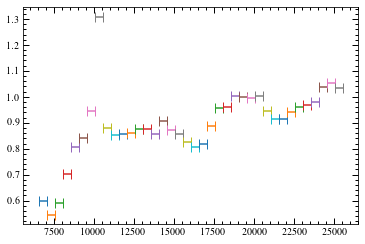

0.9298680986601626


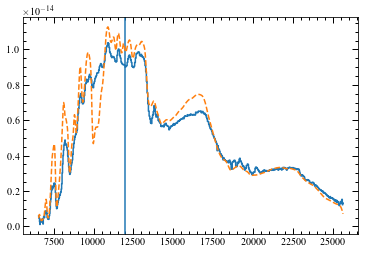

In [40]:
ratios =[]
bandwidth = 500
bands = np.arange(wir[0], wir[-1], bandwidth)
for band in bands[:-1]:
    bmask = (wir > band) & (wir < band+bandwidth)
    p_flux = np.trapz(pfi[bmask], wir[bmask])
    o_flux = np.trapz(fir[bmask], wir[bmask])
    ratios.append(o_flux/p_flux)
    plt.errorbar(band+bandwidth/2, o_flux/p_flux, xerr=bandwidth/2, capsize=5)
plt.show()
#print(ratios)

cut = 12000
c_mask = (bands[:-1] > cut)
mean_ratio = np.mean(np.array(ratios)[c_mask])
print(mean_ratio)


plt.step(wir, fir, where='mid', label='SPEX-Prism')
plt.axvline(cut)
pwr, pfr = smear(pwi, pfi,prism_res)
plt.plot(pwr, pfr*mean_ratio, label=labels[i], ls='--')
#plt.yscale('log')
plt.show()

Got the spectra from Gonzales +2019.

In [41]:
g19data = glob.glob(irpath+'PS_Gaia*')
g19data

['/home/david/work/muscles/SEDs/trappist-1/ir_data/PS_Gaia_2306-0502_M7.5_SED.txt',
 '/home/david/work/muscles/SEDs/trappist-1/ir_data/PS_Gaia_2306-0502_M7.5_phot.txt']

6333.500146865845


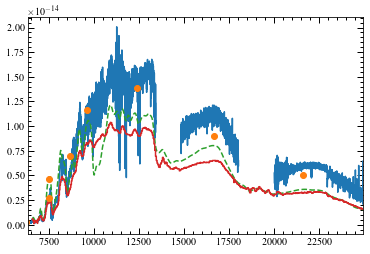

In [42]:
gw, gf, ge = np.loadtxt(g19data[0], unpack=True)
gw *=10000
gphot = np.genfromtxt(g19data[1], dtype=None, delimiter=',', names=True, encoding=None)
gpn, gpw, gpf, gpe = gphot['Band'], gphot['Wavelength'], gphot['Flux'], gphot['Error'] 
gpw*=10000
plt.plot(gw, gf)
plt.errorbar(gpw, gpf, yerr=gpe, marker='o', ls='none')
plt.plot(pwr, pfr, label=labels[i], ls='--')
plt.step(wir, fir, where='mid', label='SPEX-Prism')

plt.xlim(gw[0], gw[-1])
print(gw[0])

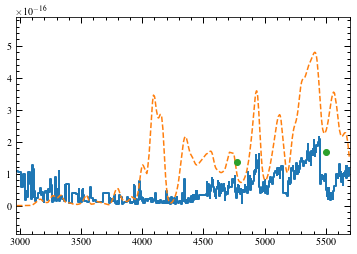

In [43]:
plt.step(wo, fo, where='mid', label='STIS G430L', lw=2)

pmask = (pw >= wo[0]) & (pw <= wo[-1])
pwi, pfi = pw[pmask], pf3[pmask]
pwi, pfi = resample.bintogrid(pwi, pfi, newx = wo)

#pwr, pfr = pw[pmask],(pf2)[pmask]
pwr, pfr = smear(pwi, pfi,250)
plt.plot(pwr, pfr, label=labels[i], ls='--')
plt.errorbar(gpw, gpf, yerr=gpe, marker='o', ls='none')
plt.xlim(wo[0]-10, wo[-1]+10)
plt.ylim(-0.9e-16, 5.9e-16)
#[plt.annotate(name.replace('_',''), (gpwi, 4e-16)) for name, gpwi in zip(gpn, gpw)]
#plt.yscale('log')
plt.show()

What if the spectrum is wrong? Bandpasses for PsG, Gaia BP?

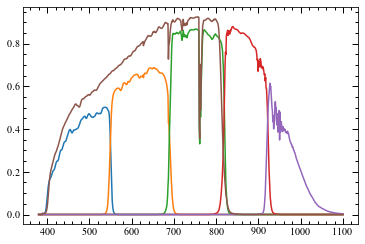

In [44]:
psbp = Table.read('/home/david/work/muscles/panstarrs_bandpasses.txt', format='ascii')
for band in ['gp1','rp1','ip1','zpi','yp1','wp1']:
    plt.plot(psbp['Wavelength'],psbp[band])

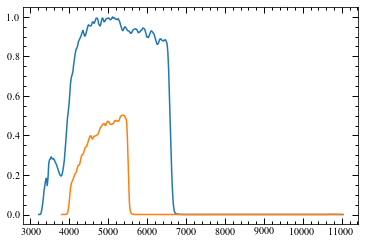

In [45]:
g_bp = Table.read('/home/david/work/filters/gaia/Bp.dat', format='ascii')
bpw, bpf = g_bp['col1'], g_bp['col2'] 
psw, psg = psbp['Wavelength']*10,psbp['gp1']
plt.plot(bpw, bpf)
plt.plot(psw, psg)


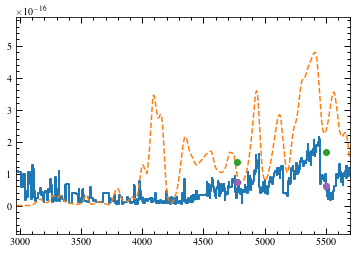

In [46]:
def make_phot(bp_w, bp_cc, w, f):
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    return np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)

def air_to_vac(wavelength):
    """
    Implements the air to vacuum wavelength conversion described in eqn 65 of
    Griesen 2006
    """
    wlum = wavelength.to(u.um).value
    return (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4)) * wavelength


go = make_phot(psw, psg, wo, fo)
bpo = make_phot(bpw, bpf, wo, fo)
phot_w = [4775.62,5500]
synphot = [go, bpo]

plt.step(wo, fo, where='mid', label='STIS G430L', lw=2)

pmask = (pw >= wo[0]) & (pw <= wo[-1])
pwi, pfi = pw[pmask], pf3[pmask]
pwi, pfi = resample.bintogrid(pwi, pfi, newx = wo)

phot_w_v = air_to_vac(phot_w*u.AA).value
gpw_v = air_to_vac(gpw*u.AA).value

#pwr, pfr = pw[pmask],(pf2)[pmask]
pwr, pfr = smear(pwi, pfi,250)
plt.plot(pwr, pfr, label=labels[i], ls='--')
plt.errorbar(gpw_v, gpf, yerr=gpe, marker='o', ls='none')
plt.errorbar(phot_w_v, synphot, marker='o', ls='none')
plt.errorbar(phot_w, synphot, marker='o', ls='none')
plt.xlim(wo[0]-10, wo[-1]+10)
plt.ylim(-0.9e-16, 5.9e-16)
#[plt.annotate(name.replace('_',''), (gpwi, 4e-16)) for name, gpwi in zip(gpn, gpw)]
#plt.yscale('log')
plt.show()

In [47]:
synphot/np.array([gpf[5], gpf[3]])
photscale = np.mean(synphot/np.array([gpf[5], gpf[3]]))
print(photscale)

0.4520822180518652


(4400, 5600)

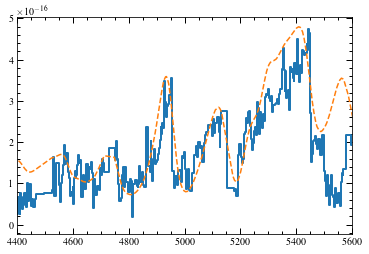

In [48]:
plt.step(wo, fo/photscale, where='mid', label='STIS G430L', lw=2)
plt.plot(pwr, pfr, label=labels[i], ls='--')
plt.xlim(4400, 5600)

Arrrrggrghhhhhshshfhijsklamakmfklwk!!!!!!  

How do you re-extract the ccd?

In [49]:
rcpath = '/home/david/work/muscles/SEDs/trappist-1/STIS/opt_recal/'

In [50]:
hdul = fits.open(rcpath+stis_opt)

In [51]:
hdul[1].data['A2Center']

array([893.3377], dtype=float32)

In [52]:
import stistools
os.environ['oref'] = rcpath
#oref="${CRDS_PATH}/references/hst/oref/"
outpath = rcpath+'newcals/'

/home/david/anaconda3/lib/python3.7/site-packages/stsci/tools/nmpfit.py:10: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/lib/python3.7/site-packages/stsci/tools/gfit.py:20: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/work/muscles/SEDs/trappist-1/STIS/opt_recal/odlm41010_flt.fits
Appending to trailer file /home/david/work/muscles/SEDs/trappist-1/STIS/opt_recal/newcals/test.trl
Running x1d on /home/david/work/muscles/SEDs/trappist-1/STIS/opt_recal/odlm41010_flt.fits
  ['cs6.e', '/home/david/work/muscles/SEDs/trappist-1/STIS/opt_recal/odlm41010_flt.fits', '/home/david/work/muscles/SEDs/trappist-1/STIS/opt_recal/newcals/test_sx1.fits', '-v', '-back', '-cte', '-disp', '-hel', '-flux', '-o1', '15', '-o2', '15', '-bm', '-bo', '3', '-a', 'unweighted']


(0, 5e-16)

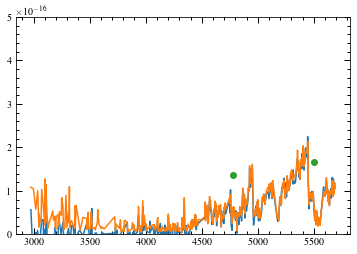

In [53]:
for fl in glob.glob(outpath+'*.fits'):
    os.remove(fl)
oflt = glob.glob(rcpath+'*flt*')[0]
print(oflt)
stistools.x1d.x1d(oflt, output=outpath+"test_sx1.fits", verbose=True, trailer=outpath+"test.trl", bk1offst=15, bk2offst=15)
#stistools.calstis.calstis(oflt, outroot=outpath+"test", verbose=True, trailer=outpath+"test.trl")
dt = fits.getdata(outpath+'test_sx1.fits',1)[0]
wn, fn = dt['WAVELENGTH'][dt['DQ']==0], dt['FLUX'][dt['DQ']==0]
mask = (wn <3355) | (wn > 3365)
plt.plot(wn[mask], fn[mask])
plt.plot(wo, fo)
photmask = (gpw > wn[0]) & (gpw < wn[-1])
plt.errorbar(gpw[photmask], gpf[photmask], marker='o', ls='none')
plt.ylim(0, 5e-16)

In [54]:
from pylab import cm  
from matplotlib.colors import LogNorm

In [56]:
#h2d = fits.open(outpath+'test_sx2.fits')
#dt = h2d[1].data
#hdr1 = h2d[1].header
#ompic = hdr1['OMEGAPIX']
#dt = fits.getdata(outpath+'test_sx2.fits',1)
#plt.imshow(dt,cmap=cm.gray_r, norm = LogNorm())

In [57]:
#x = np.arange(len(dt[0]))
#fx = []
#bk  = []
#col_mask = (x >= 980) & (x < 990)
#bk_mask = (x >= 970) & (x < 975) | (x >= 995) & (x < 1000)
#for xi in x:
 #   col = dt[:,xi]
  #  fxi = np.trapz(col[col_mask], x[col_mask])*ompic
  #  bki = np.trapz(col[bk_mask], x[col_mask])*ompic
  #  fx.append(fxi-bki)
   # bk.append(bki)
#plt.plot(x, np.array(fx))
#plt.plot(wn[mask]-wn[0], fn[mask])
#plt.axhline(1.36671706682e-16, ls='--', c='k')
#plt.ylim(0, 1e-15)
#plt.show()
#plt.plot(x, bk)

In [58]:
#h2d[1].header

Trying new phoenix models from http://perso.ens-lyon.fr/france.allard/

In [59]:
npSpectra = glob.glob('lyon_phoenix/*spec.7')
npSpectra

['lyon_phoenix/lte027.0-5.0-0.0a+0.0.BT-Settl.spec.7',
 'lyon_phoenix/lte027.0-5.5-0.0a+0.0.BT-Settl.spec.7',
 'lyon_phoenix/lte026.0-5.5-0.0a+0.0.BT-Settl.spec.7',
 'lyon_phoenix/lte026.0-5.0-0.0a+0.0.BT-Settl.spec.7']

3085214969.5343633
3085216117.4590173
2505166002.780053
2505165976.4368706
2516589605.714035
2516590392.931581


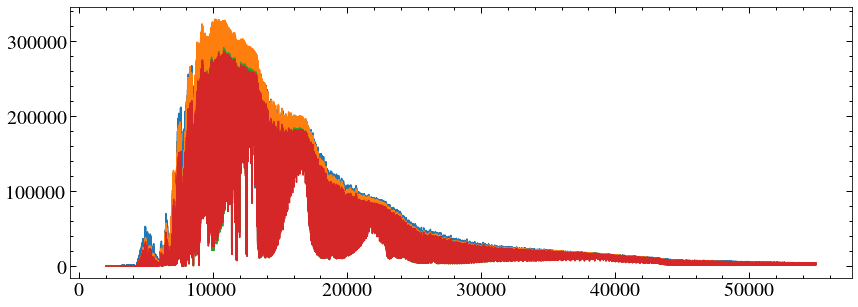

In [105]:
#nps = Table.read(npSpectra[0], format='ascii',  fast_reader={'exponent_style': 'D'})
#nps = np.loadtxt(npSpectra[0], dtype=float)
wavemin=2000, # in angstroms
wavemax=55000
DF = -8.

ts = [2700.0, 2700.0, 2600.0, 2600.0]
gs = [5.0, 5.5, 5.5, 5.0]
waves = []
fluxes = []
spectra = []
for i, sp in enumerate(npSpectra):
    #params = {'Teff':ts[i], 'logg':gs[i], 'FeH':0.0, 'aM':0.0}
    phoenixR = ascii.read(sp,format="fixed_width_no_header",col_starts=(0,14),col_ends=(12,25),delimiter=" ",names=('Wave','Spec'))
    #print(len(phoenixR['Wave']))
    ph1, jj = np.unique(np.array(phoenixR['Wave']),return_index=True)
    phoenix = np.zeros((len(ph1),2))
    for kk in range(len(jj)):
        phoenix[kk,1] = np.float64(phoenixR['Spec'][jj[kk]].replace("D","E"))
    phoenix[:,0] = ph1
    ind = np.where( (phoenix[:,0] <= wavemax) & (phoenix[:,0] >= wavemin))[0]  
    xraw = phoenix[ind,0]
    yraw = np.power(10.,phoenix[ind,1] + DF)#.tolist()
    waves.append(xraw)
    fluxes.append(yraw)
   # params.update({'flux':yraw})
   # spectra.append(params)
   # print(len(params['flux']))
    #plt.plot(xraw, params['flux'])

nwave = np.min([len(w) for w in waves])
for w in waves:
    if len(w) == nwave:
        wav = w

for i, sp in enumerate(npSpectra):
    flux = fluxes[i]
    if len(waves[i]) > nwave:
        print(np.trapz(flux, waves[i]))
        flux = interp1d(waves[i], flux, fill_value='extrapolate')(wav)
        print(np.trapz(flux, wav))
            #wav = waves[i]
    params = {'Teff':ts[i], 'logg':gs[i], 'FeH':0.0, 'aM':0.0, 'flux': flux}
    spectra.append(params)
    plt.plot(wav, params['flux'])
            
            
 

{'Teff': 2628.0, 'logg': 5.21, 'FeH': 0.04, 'aM': 0}
[[2700.0, 5.0], [2700.0, 5.5], [2600.0, 5.5], [2600.0, 5.0]]
[2628.0, 5.21]
<class 'list'>
<class 'list'>
[array([9.64905985e-08, 2.55039237e-08, 4.15433008e-08, ...,
       3.23146904e+03, 3.18786558e+03, 2.83791903e+03]), array([1.35768806e-07, 2.35866357e-08, 4.40902945e-08, ...,
       3.19153786e+03, 3.14774831e+03, 2.90870716e+03]), array([3.79109790e-08, 4.65745857e-09, 7.36770112e-09, ...,
       2.84511614e+03, 2.80672589e+03, 2.60195631e+03]), array([2.40222123e-08, 2.33949973e-09, 4.60831333e-09, ...,
       2.91675533e+03, 2.87276433e+03, 2.53688044e+03])]


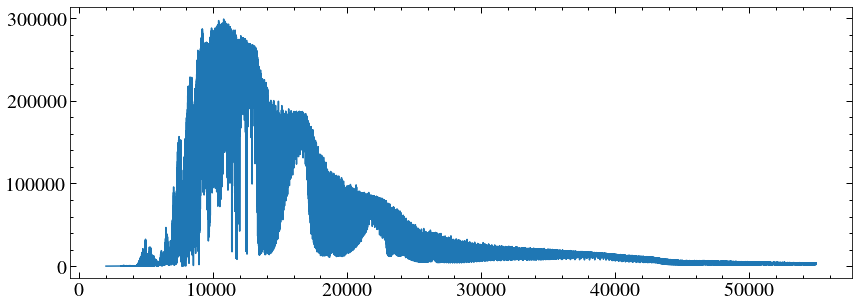

In [112]:
from scipy.interpolate import griddata, interp1d



def interp_flux(spectra, params_to_interp, star_params):
    """
    build the new spectrum
    """
    out_vals = [star_params[p] for p in params_to_interp]
    in_vals = [[s[p] for p in params_to_interp] for s in spectra]
    fluxes = [(s['flux']) for s in spectra]
    #fluxes = [np.random.random(100) for s in spectra]
   # print(type(fluxes[0]))
    if len(params_to_interp) == 1:
        in_vals = [s[params_to_interp[0]] for s in spectra]
        new_flux = interp1d(in_vals, fluxes, axis=0, fill_value='extrapolate')(star_params[params_to_interp[0]])
    else:
     #   out_vals = [star_params[p] for p in params_to_interp]
        in_vals = [[s[p] for p in params_to_interp] for s in spectra]
        print(in_vals)
        print(out_vals)
        print(type(in_vals))
        print(type(out_vals))
        print(fluxes)
        new_flux = griddata(in_vals, fluxes, out_vals)[0]
    return new_flux

star_params = g19_params
print(star_params)
params_to_interp = ['Teff', 'logg']
nflux = interp_flux(spectra, params_to_interp, star_params)
nwave = wav
plt.plot(nwave, nflux)


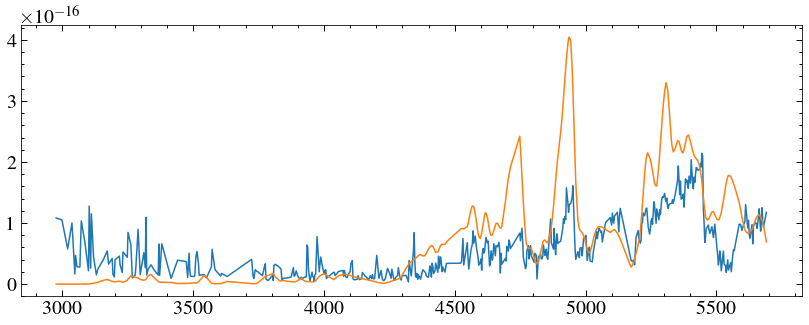

In [127]:
plt.plot(wo, fo)
#print(len(nwave))
pw, pf = nwave, nflux*scales[2]/1e-8
#print(len(pw), len(pf))
#plt.plot(pw, pf)
pmask = (pw >= wo[0]) & (pw <= wo[-1])
pwi, pfi = pw[pmask], pf[pmask]
#plt.plot(pwi, pfi)
pwi, pfi = resample.bintogrid(pwi, pfi, newx = wo)
#plt.plot(pwi, pfi)

pwr, pfr = smear(pwi, pfi,500)
plt.plot(pwr, pfr)


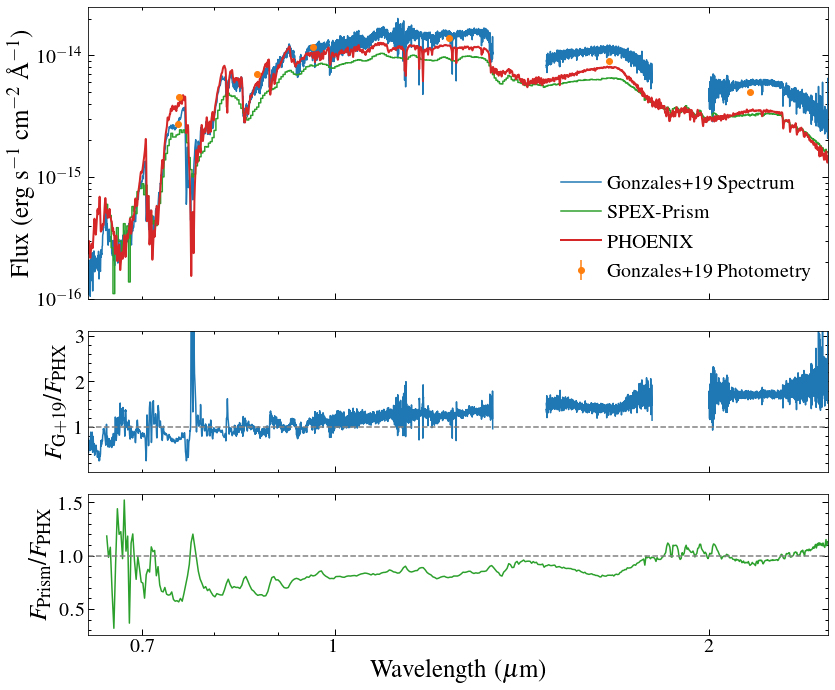

In [235]:
gw, gf, ge = np.loadtxt(g19data[0], unpack=True)
gw *=10000
gphot = np.genfromtxt(g19data[1], dtype=None, delimiter=',', names=True, encoding=None)
gpn, gpw, gpf, gpe = gphot['Band'], gphot['Wavelength'], gphot['Flux'], gphot['Error'] 
gpw*=10000

plt.figure(figsize= (12, 10))


plt.subplot(211)
plt.plot(gw/10000, gf, label = 'Gonzales+19 Spectrum')
plt.errorbar(gpw/10000, gpf, yerr=gpe, marker='o', ls='none', label = 'Gonzales+19 Photometry')
#plt.plot(pwr, pfr, ls='--')
plt.step(wir/10000, fir, where='mid', label='SPEX-Prism')
pwr, pfr = smear(pw, pf,sxd_res)
plt.plot(pwr/10000, pfr, lw=2, label='PHOENIX')

#mwr, mfr = smear(mw, mf*scales[1]/1e-8,sxd_res)
#plt.plot(mwr, mfr, ls='--')

plt.xlim(gw[0]/10000, gw[-1]/10000)
plt.ylim(1e-16, 2.5e-14)
#print(gw[0])
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=4)
#plt.xlabel('Wavelength (\AA)', size=20)
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=25)
plt.xticks([1,2],['',''])

plt.subplot(413)
pwi, pfi = resample.bintogrid(pwr, pfr, newx = gw)
plt.plot(gw/10000, gf/pfi)
plt.axhline(1, ls ='--', c='0.5')
plt.ylim(0.001, 3.1)
plt.xscale('log')
plt.ylabel('$F_{\mathrm{G+19}}$/$F_{\mathrm{PHX}}$', size=25)
plt.xlim(gw[0]/10000, gw[-1]/10000)
plt.xticks([1,2],['',''])
plt.xticks(visible=False)

plt.subplot(414)
pwr, pfr = smear(pw, pf,prism_res)
pwi, pfi = resample.bintogrid(pwr, pfr, newx = wir)
plt.plot(wir/10000, fir/pfi, c='C2')
plt.axhline(1, ls ='--', c='0.5')
plt.xscale('log')
plt.ylabel('$F_{\mathrm{Prism}}$/$F_{\mathrm{PHX}}$', size=25)
plt.xlabel('Wavelength ($\mu$m)', size=25)
plt.xlim(gw[0]/10000, gw[-1]/10000)
plt.xticks([0.7, 1,2],['0.7','1','2'])
plt.tight_layout()
plt.subplots_adjust(hspace=0.15)
plt.savefig('ir_compare.png', dpi=150)

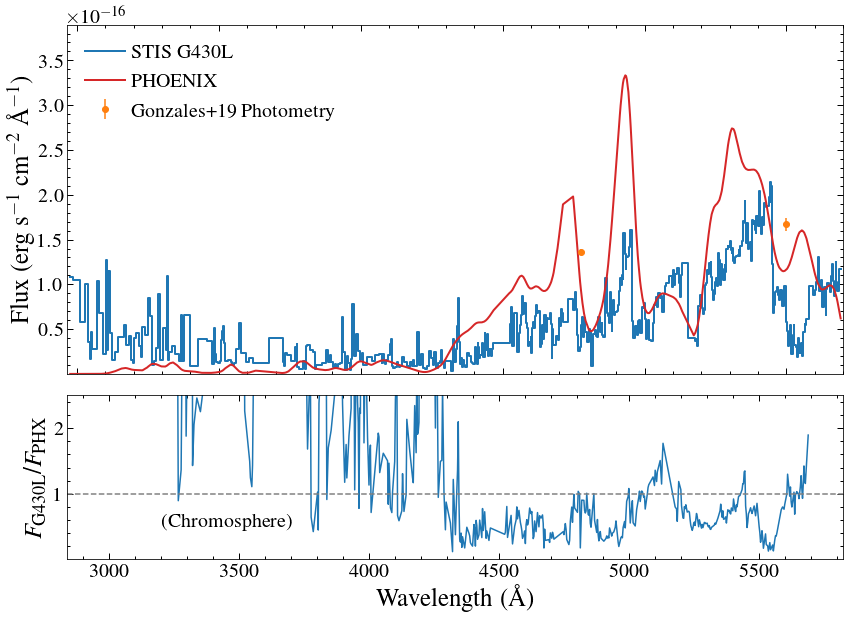

In [234]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 9))
gs = GridSpec(3, 1, figure=fig)


plt.subplot(gs[:-1, 0])
plt.step(wo, fo, where='mid', label='STIS G430L', lw=2)

pmask = (pw >= wo[0]) & (pw <= wo[-1])
pwi, pfi = pw[pmask], pf[pmask]
pwi, pfi = resample.bintogrid(pwi, pfi, newx = wo)

pwr, pfr = smear(pwi, pfi,250)
plt.plot(pwr, pfr, lw=2, label='PHOENIX', c='C3',)
plt.errorbar(gpw, gpf, yerr=gpe, marker='o', ls='none', c='C1', label = 'Gonzales+19 Photometry')
plt.xlim(wo[0]-10, wo[-1]+10)
plt.ylim(0.001e-16, 3.9e-16)
plt.legend()
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=25)
plt.xticks(visible=False)

plt.subplot(gs[2, 0])
plt.plot(wo, fo/pfr)
plt.ylabel('$F_{\mathrm{G430L}}$/$F_{\mathrm{PHX}}$', size=25)
plt.xlabel('Wavelength (\AA)', size=25)
plt.ylim(0.0001, 2.5)
plt.axhline(1, ls ='--', c='0.5')
plt.annotate('(Chromosphere)', (3200, 0.5))
plt.tight_layout()
plt.savefig('opt_compare.png', dpi=150)

In [236]:
savedat = Table([pw*u.AA, pf*u.erg/u.s/u.cm**2/u.AA], names=['WAVELENGTH', 'FLUX'])
ascii.write(savedat, 'lyon_phoenix_2628_5.21_scaled.ecsv', format='ecsv', overwrite=True)